In [ ]:
import numpy as np
from util import generate_sparse_least_squares
from optim import primal_gradient as pg, dual_gradient as dg, nesterov_accelerated_gradient as nag

In [31]:
import numpy as np

# Define the data generation function
def generate_sparse_least_squares(m, n, rho):
    A = np.random.uniform(-1, 1, (m, n))
    x_star = np.zeros(n)
    non_zero_indices = np.random.choice(n, int(n * rho), replace=False)
    x_star[non_zero_indices] = np.random.normal(0, 1, int(n * rho))
    noise = np.random.normal(0, 0.1, m)
    b = np.dot(A, x_star) + noise
    return A, b, x_star

# Define the LASSO functions
def lasso_objective(X, y, beta, lambda_):
    n = len(y)
    residual = y - np.dot(X, beta)
    loss = 0.5 * np.dot(residual, residual) / n
    penalty = lambda_ * np.linalg.norm(beta, 1)
    return loss + penalty


def lasso_gradient(X, y, beta, lambda_):
    n = len(y)
    residual = y - np.dot(X, beta)
    gradient_loss = -np.dot(X.T, residual) / n
    gradient_penalty = lambda_ * np.sign(beta)
    return gradient_loss + gradient_penalty

def primal_gradient_descent(X, y, lambda_, learning_rate=0.01, max_iterations=1000, tol=1e-6):
    n, p = X.shape
    beta = np.zeros(p)
    loss_history = []
    beta_history = [beta.copy()]

    for i in range(max_iterations):
        gradient = lasso_gradient(X, y, beta, lambda_)
        beta_new = beta - learning_rate * gradient
        
        if i > 0:
            gap = np.linalg.norm(beta_new - beta) / np.linalg.norm(beta)
            if gap < tol:
                print(f"Converged at iteration {i}")
                break
        beta = beta_new
        loss_history.append(lasso_objective(X, y, beta, lambda_))
        beta_history.append(beta.copy())
    
    return beta, loss_history, beta_history

# Generate synthetic data
m, n, rho = 100, 200, 0.1
lambda_ = 0.1
A, b, x_star = generate_sparse_least_squares(m, n, rho)

# Run the primal gradient descent
beta_optimized, loss_history, beta_history = primal_gradient_descent(A, b, lambda_)
print("Optimized coefficients:\n", beta_optimized)


Optimized coefficients:
 [ 4.77840945e-05 -4.34358989e-04  1.32564168e-03  1.77777771e-03
  8.60495187e-04 -9.57138363e-04 -1.22407473e-02 -1.65889790e-01
  5.08269815e-05  2.52235114e-01  1.09748793e-01 -1.15321659e-03
  1.08280294e-03 -3.44269140e-04  1.25909524e-03  1.11270091e-03
  1.14399545e-03  2.28943741e-01  1.33774450e-03  6.43522612e-05
  1.91397850e-04  6.01150878e-04  3.44375059e-04 -7.64212267e-04
 -8.10264657e-01 -1.55976394e-03 -2.77559359e-04 -1.40781313e-03
 -3.26022008e-04  1.70325660e-04 -2.60190592e-04  3.19930150e-04
 -1.69500447e-04 -1.88516353e-04  6.85551954e-04 -2.40652886e-04
  3.98384885e-04 -5.27945190e-04 -9.59219845e-05 -6.96388454e-04
  1.01630101e-03 -8.21809843e-04  8.56193956e-04  5.92385130e-04
 -6.95166102e-04  1.70973605e-04  5.92971117e-04 -3.66820136e-04
 -5.44172928e-04  1.22202921e-04 -2.89761429e-04  5.66165292e-02
 -2.53770901e-04  9.55199956e-02 -6.81266414e-04  7.05880757e-04
 -1.47754858e-03 -1.78616383e-04  2.60943711e-04  3.40648943e-05


In [48]:
A, b, x_star = generate_sparse_least_squares(m, n, rho)

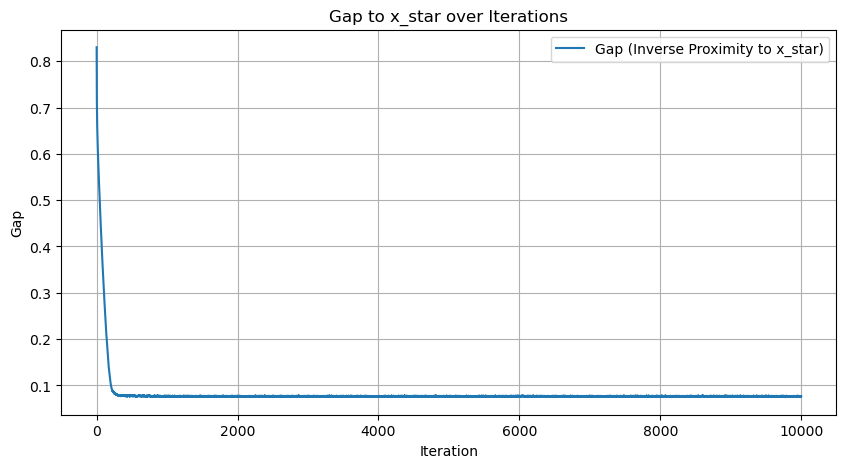

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def primal_gradient_descent(A, b, x_star, lambda_, learning_rate=0.01, max_iterations=1000, tol=1e-6):
    n = A.shape[1]
    beta = np.zeros(n)  # Initialize coefficients to zero
    loss_history = []
    gap_history = []  # To store the gap values relative to x_star

    # Initial distance to x_star
    initial_distance = np.linalg.norm(x_star - beta)

    for i in range(max_iterations):
        # Compute the gradient of the LASSO objective
        residual = b - np.dot(A, beta)
        gradient_loss = -np.dot(A.T, residual)
        gradient_penalty = lambda_ * np.sign(beta)
        gradient = gradient_loss + gradient_penalty
        
        # Update beta
        beta -= learning_rate * gradient
        
        # Current distance to x_star
        current_distance = np.linalg.norm(x_star - beta)
        
        # Calculate the new gap definition
        gap = current_distance / initial_distance if initial_distance > 0 else 0
        gap_history.append(gap)
        
        # Check for convergence
        if gap < tol:
            print(f"Converged at iteration {i}")
            break
        
        # Append current loss
        loss = 0.5 * np.sum(residual**2) + lambda_ * np.linalg.norm(beta, 1)
        loss_history.append(loss)
    
    return beta, loss_history, gap_history

# Assume A, b, x_star are already defined
# Example parameters
lambda_ = 0.4
learning_rate = 0.01
max_iterations = 10000
tol = 1e-12

beta_optimized, loss_history, gap_history = primal_gradient_descent(A, b, x_star, lambda_, learning_rate, max_iterations, tol)

# Plotting the gap
plt.figure(figsize=(10, 5))
plt.plot(gap_history, label='Gap (Inverse Proximity to x_star)')
plt.xlabel('Iteration')
plt.ylabel('Gap')
plt.title('Gap to x_star over Iterations')
plt.legend()
plt.grid(True)
plt.show()


In [46]:
gap_history

[0.79996704788858,
 0.7451569833675524,
 0.7161607195860741,
 0.6981855487130989,
 0.6854028886765758,
 0.67579871006218,
 0.6678462778308925,
 0.6610861965713039,
 0.6549709141059555,
 0.6494092526008914,
 0.6441100399777075,
 0.6391191337559614,
 0.6343661791302416,
 0.629684367910201,
 0.6251857622746242,
 0.6208224503472556,
 0.6164624652660826,
 0.612236454282402,
 0.6080096307655741,
 0.6038908578008304,
 0.5997477294511303,
 0.5957257443453884,
 0.5916759539395334,
 0.5877377513530201,
 0.5837508701104467,
 0.579878370670772,
 0.5759479136462812,
 0.5721351368807119,
 0.5682388712753035,
 0.5644764822607559,
 0.56064438988425,
 0.5569486568374902,
 0.5531648689348314,
 0.5494893395646466,
 0.545711284090599,
 0.5421077617949309,
 0.5383596472367518,
 0.5348001736385413,
 0.5311062184359132,
 0.52759295485225,
 0.523947464585086,
 0.5204755451593525,
 0.5168208584652434,
 0.5133884446383603,
 0.5097731152150308,
 0.5067143128538772,
 0.5031732106410457,
 0.5001975943524737,
 0.49

In [45]:
gap_history[-1]

0.12298880832344394

In [19]:
def generate_test_data(m, m_star, n, rho):
    """_summary_

    Args:
        m (_type_): _description_
        m_star (_type_): m_star < m, the number of components of the optimal 
        solution x_star of problem
        n (_type_): _description_
        rho (_type_): rho > 0, parameter responsible for the size of x_star
    """
    # Generate randomly matrix B in R^{m x n} with elements uniformly distributed in [-1, 1]
    B = np.random.uniform(-1, 1, (m, n))
    # Generate randomly vector v_star in R^m with elements uniformly distributed in [0, 1]
    v_star = np.random.uniform(0, 1, m)
    # Define y_star = v_star / ||v_star||_2
    y_star = v_star / np.linalg.norm(v_star, ord=2) # normalize v_star
    # Compute B^T * y_star
    # sort the entries of B^T * y_star in decreasing order of their absolute values
    B_transpose_y_star = np.dot(B.T, y_star)
    sorted_indices = np.argsort(-np.abs(B_transpose_y_star))
    B_sorted = B[:, sorted_indices]
    # for i = 1, 2, ..., n, define a_i = alpha_i * B_i, where
    # alpha_i = 1 / |<b_i, y_star>| for i = 1, 2, ..., m_star
    # alpha_i = epsilon_i / |<b_i, y_star>| otherwise
    # where epsilon_i are uniformly distributed in [0, 1]
    A = np.zeros((m, n))
    for i in range(n):
        denominator = np.abs(np.dot(B_sorted[:, i], y_star))
        if i < m_star:
            numerator = 1
        else:
            numerator = np.random.uniform(0, 1)  # epsilon_i
        alpha_i = numerator / denominator
        A[:, i] = alpha_i * B_sorted[:, i]
    # for i = 1, 2, ..., n, generate components of the primal solution x_star:
    # x_star_i = epsilon_i * sign(<a_i, y_star>) for i <= m_star and 0 otherwise
    # where epsilon _i are uniformly distributed in [0, rho / sqrt(m_star)]
    x_star = np.zeros(n)
    for i in range(m_star):
        epsilon_i = np.random.uniform(0, rho / np.sqrt(m_star))
        x_star[i] = epsilon_i * np.sign(np.dot(A[:, i], y_star))
    # Generate the vector b = A * x_star
    b = y_star + np.dot(A, x_star)
    phi_star = 1/2 * np.linalg.norm(y_star)**2 + np.linalg.norm(x_star, ord=1)
    return A, b, x_star, phi_star